In [2]:
import random

### Creating a basic Environment and Agent

In [3]:
class Environment:

    #Initialise Internal state
    #Limit number of steps
    def __init__(self):
        self.steps_left = 10

    #Current environement which is always zero in this case
    def get_observation(self) -> list[float]:
        return [0.0, 0.0, 0.0]

    #Query set of possible actions
    def get_actions(self) -> list[int]:
        return [0, 1]
    
    #Signals when episode is over (episode is environment-agent interactions which can be finite of infinite)
    def is_done(self) -> bool:
        return self.steps_left == 0

    #Here reward of action is random
    def action(self, action: int) -> float:
        if self.is_done():
            raise Exception("Game is over")
        self.steps_left -= 1
        return random.random()

In [4]:
class Agent:
     def __init__(self):                                                                
        self.total_reward = 0.0

    #Constructor
    #Initialise reward counter
     def step(self, env: Environment):
        current_obs = env.get_observation()
        actions = env.get_actions()
        reward = env.action(random.choice(actions))
        self.total_reward += reward

In [4]:
env = Environment()
agent = Agent()
while not env.is_done():
    agent.step(env)
    print("Total reward got: %.4f" % agent.total_reward)

Total reward got: 0.2943
Total reward got: 1.1827
Total reward got: 1.5452
Total reward got: 2.1744
Total reward got: 2.7393
Total reward got: 3.7271
Total reward got: 4.5165
Total reward got: 4.6750
Total reward got: 5.2035
Total reward got: 5.2846


## CartPole

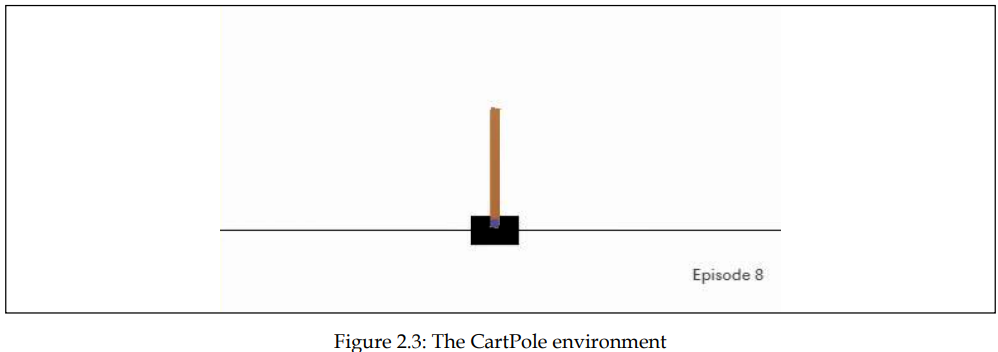

Stick tends to fall right or left and you need to balance it by
moving the platform to the right or left on every step.

https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

### Explore Environment

In [5]:
import gym
e = gym.make('CartPole-v1')

In [20]:
obs = e.reset()
obs

(array([ 0.00184696,  0.0437621 , -0.02684989,  0.04611047], dtype=float32),
 {})

In [21]:
e.action_space

Discrete(2)

In [27]:
e.action_space.sample()

1

In [22]:
e.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [23]:
e.step(0)

(array([ 0.0027222 , -0.15096475, -0.02592768,  0.33020255], dtype=float32),
 1.0,
 False,
 False,
 {})

### Random CartPole Agent

In [29]:
env = gym.make("CartPole-v1")
total_reward = 0.0
total_steps = 0
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    if done:
        break
    print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))

Episode done in 1 steps, total reward 1.00
Episode done in 2 steps, total reward 2.00
Episode done in 3 steps, total reward 3.00
Episode done in 4 steps, total reward 4.00
Episode done in 5 steps, total reward 5.00
Episode done in 6 steps, total reward 6.00
Episode done in 7 steps, total reward 7.00
Episode done in 8 steps, total reward 8.00
Episode done in 9 steps, total reward 9.00
Episode done in 10 steps, total reward 10.00
Episode done in 11 steps, total reward 11.00
Episode done in 12 steps, total reward 12.00
Episode done in 13 steps, total reward 13.00
Episode done in 14 steps, total reward 14.00
Episode done in 15 steps, total reward 15.00
Episode done in 16 steps, total reward 16.00
Episode done in 17 steps, total reward 17.00


### Adding Wrapper

The Wrapper class inherits the Env class and adds an extra layer of functionality

By issuing the random actions, we make our agent
explore the environment and from time to time drift away from the beaten track of
its policy. Too much or too little/no exploration is detrimental to performance

In [36]:
from typing import TypeVar
import random

Action = TypeVar('Action')

class RandomActionWrapper(gym.ActionWrapper):
    def __init__(self, env, epsilon=0.1):
        super().__init__(env)
        self.epsilon = epsilon
    
    def action(self, action: Action) -> Action:
        if random.random() < self.epsilon:
            print("Random!")
            return self.env.action_space.sample()
        return action

In [39]:
env = RandomActionWrapper(gym.make("CartPole-v1"))
obs = env.reset()
total_reward = 0.0
while True:
    obs, reward, done,_, _ = env.step(0)
    total_reward += reward
    if done:
        break
    print("Reward got: %.2f" % total_reward)

Reward got: 1.00
Reward got: 2.00
Reward got: 3.00
Random!
Reward got: 4.00
Reward got: 5.00
Reward got: 6.00
Reward got: 7.00
Reward got: 8.00
Reward got: 9.00


## Cross Entropy

##### Cross-entropy method is model-free, policy-based, and on-policy, which means the following:
##### • It doesn't build any model of the environment; informs the agent it's action at every step
##### • It approximates the policy of the agent
##### • It requires fresh data obtained from the environment

1. Play N number of episodes using our current model and environment.
2. Calculate the total reward for every episode and decide on a reward
boundary. Usually, we use some percentile of all rewards, such as 50th
or 70th.
3. Throw away all episodes with a reward below the boundary.
4. Train on the remaining "elite" episodes using observations as the input and
issued actions as the desired output.
5. Repeat from step 1 until we become satisfied with the result.

### Cross-entropy Method on CartPole

Model's core is a one-hidden-layer
NN, with rectified linear unit (ReLU) and 128 hidden neurons (which is absolutely
arbitrary)

In [20]:
#Imports
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple
import numpy as np
from tensorboardX import SummaryWriter

In [21]:
HIDDEN_SIZE = 128       # Neuron Count
BATCH_SIZE = 16         # Episode Count
PERCENTILE = 70         # Leaves top 30& of episodes sorted by reward

In [139]:
#The output from the NN is a probability distribution over actions
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

In [140]:
Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])  #Single step made by agent

In [163]:
#Generates Batches which are lists of episode instances
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()[0]
    required_type = type(obs)
    sm = nn.Softmax(dim=1)      #Softmax layer to convert NN output prob distribution of actions
    while True:
        #Convert current observation to tensor and pass thorugh NN
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        #Sample action
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done,_, _ = env.step(action)
        #Record values
        episode_reward += reward
        step = EpisodeStep(observation=obs, action=action)
        episode_steps.append(step)
        #
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps)
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch                     # Yield works like 'return' but will output a generator
                batch = []    
        obs = next_obs
        if type(obs) == required_type:
            continue
        obs = obs[0]

In [164]:
#Calculate boundary reward to filter elite episodes to train on
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean

In [165]:
env = gym.make("CartPole-v1")
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

#Create required objects
net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)
writer = SummaryWriter(comment="-cartpole")

#Training Loop
for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    #Filter elite episodes
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    
    #Calculate cross-entropy between NN output and agent actions to optimize NN
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()

    print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
        iter_no, loss_v.item(), reward_m, reward_b))
    writer.add_scalar("loss", loss_v.item(), iter_no)
    writer.add_scalar("reward_bound", reward_b, iter_no)
    writer.add_scalar("reward_mean", reward_m, iter_no)

    if reward_m > 199:
        print("Solved!")
        break
writer.close()

0: loss=0.689, reward_mean=24.2, rw_bound=27.5
1: loss=0.695, reward_mean=22.6, rw_bound=23.5
2: loss=0.684, reward_mean=26.9, rw_bound=33.5
3: loss=0.685, reward_mean=27.6, rw_bound=26.5
4: loss=0.672, reward_mean=33.8, rw_bound=36.5
5: loss=0.665, reward_mean=25.4, rw_bound=27.5
6: loss=0.663, reward_mean=35.5, rw_bound=41.5
7: loss=0.661, reward_mean=32.1, rw_bound=39.0
8: loss=0.644, reward_mean=32.8, rw_bound=39.5
9: loss=0.630, reward_mean=40.9, rw_bound=53.0
10: loss=0.632, reward_mean=53.2, rw_bound=63.0
11: loss=0.623, reward_mean=48.6, rw_bound=57.5
12: loss=0.625, reward_mean=44.4, rw_bound=53.0
13: loss=0.615, reward_mean=64.0, rw_bound=73.5
14: loss=0.600, reward_mean=57.5, rw_bound=60.5
15: loss=0.615, reward_mean=59.6, rw_bound=63.0
16: loss=0.584, reward_mean=55.5, rw_bound=65.0
17: loss=0.577, reward_mean=59.9, rw_bound=72.0
18: loss=0.587, reward_mean=68.5, rw_bound=78.5
19: loss=0.589, reward_mean=52.6, rw_bound=56.0
20: loss=0.574, reward_mean=89.6, rw_bound=94.0
21

Episode number is 16 (batchsize) X 37 which is 592

## Q-Learning

##### Model-free
    Doesn't build model of environment, informs agent action instead
##### Values-based
    Updates value function based on Bellman equation
##### Off-policy
    Learns optimal policy independent of agent actions

How it works: https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c

In [28]:
import gym 
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
env = gym.make('CartPole-v1')

In [5]:
state_space = 4 # number of states
action_space = 2 # number of possible actions

def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

In [24]:
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 100, epsilon = 0.2):
    
    rewards = 0
    steps = 0
    for episode in range(1,episodes+1):
        steps += 1 
        current_state = Discrete(env.reset()[0],bins)      
        score = 0
        done = False
        while not done: 
            if episode%timestep==0:
                env.render()
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            observation, reward, done,_, info = env.step(action)
            next_state = Discrete(observation,bins)
            score+=reward
          
            if not done:
                    max_future_q = np.max(q_table[next_state])
                    current_q = q_table[current_state+(action,)]
                    new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                    q_table[current_state+(action,)] = new_q
            current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            if score > 195 and steps >= 100:
                print('Solved')
        if episode % timestep == 0:
            print(reward / timestep)

In [41]:
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 5000, epsilon = 0.2):
    rewards = 0
    solved = False 
    steps = 0 
    runs = [0]
    data = {'max' : [0], 'avg' : [0]}
    start = time.time()
    ep = [i for i in range(0,episodes + 1,timestep)] 
    
    for episode in range(1,episodes+1):
        
        current_state = Discrete(env.reset()[0],bins) # initial observation
        score = 0
        done = False
        temp_start = time.time()
        
        while not done:
            steps += 1 
            ep_start = time.time()
            if episode%timestep == 0:
                env.render()
                
            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[current_state])
            
            observation, reward, done,_, info = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward
            

            if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            if score > 195 and steps >= 100 and solved == False: # considered as a solved:
                solved = True
                print('Solved in episode : {} in time {}'.format(episode, (time.time()-ep_start)))
        
        # Timestep value update
        if episode%timestep == 0:
            print('Episode : {} | Reward -> {} | Max reward : {} | Time : {}'.format(episode,rewards/timestep, max(runs), time.time() - ep_start))
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            if rewards/timestep >= 199: 
                print('Solved in episode : {}'.format(episode))
            rewards, runs= 0, [0] 
            
    if len(ep) == len(data['max']):
        plt.plot(ep, data['max'], label = 'Max')
        plt.plot(ep, data['avg'], label = 'Avg')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc = "upper left")
        
    env.close()

Solved in episode : 358 in time 0.0
Episode : 1000 | Reward -> 82.231 | Max reward : 411.0 | Time : 0.0010416507720947266
Episode : 2000 | Reward -> 112.461 | Max reward : 500.0 | Time : 0.0010004043579101562
Episode : 3000 | Reward -> 119.026 | Max reward : 456.0 | Time : 0.001911163330078125
Episode : 4000 | Reward -> 136.38 | Max reward : 585.0 | Time : 0.000997781753540039
Episode : 5000 | Reward -> 164.666 | Max reward : 636.0 | Time : 0.0009996891021728516


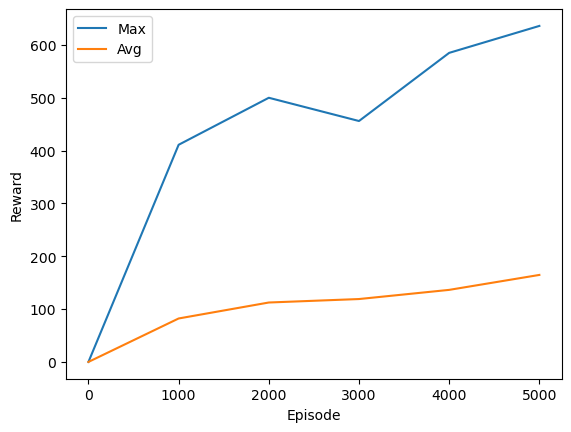

In [42]:
# TRANING
q_table, bins = Qtable(len(env.observation_space.low), env.action_space.n)

Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5000, timestep = 1000)

#### Average Reward continues to increase which is desirable. 
##### Reached threshold in less episodes than cross entropy method
In the more complex problems, the Q-table wouldn’t handle a huge number of states and actions, which makes it inefficient to use. The Deep Q-Network is a solution to this problem.

## DQN (Deep Q-Network)

Q-Learning struggles with large number of states. For cartpole, the combinations of the 4 float states is extremely large.

As a solution to this problem, we can use a nonlinear representation that maps both
the state and action onto a value. In machine learning, this is called a "regression
problem. This is where Neural Nets can be used                .

### PTAN to solve CartPole

In [44]:
import gym
import ptan
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [45]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
TGT_NET_SYNC = 10
GAMMA = 0.9
REPLAY_SIZE = 1000
LR = 1e-3
EPS_DECAY=0.99

In [50]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x.float())


@torch.no_grad()
def unpack_batch(batch, net, gamma):
    states = []
    actions = []
    rewards = []
    done_masks = []
    last_states = []
    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        done_masks.append(exp.last_state is None)
        if exp.last_state is None:
            last_states.append(exp.state)
        else:
            last_states.append(exp.last_state)

    states_v = torch.tensor(states)
    actions_v = torch.tensor(actions)
    rewards_v = torch.tensor(rewards)
    last_states_v = torch.tensor(last_states)
    last_state_q_v = net(last_states_v)
    best_last_q_v = torch.max(last_state_q_v, dim=1)[0]
    best_last_q_v[done_masks] = 0.0
    return states_v, actions_v, best_last_q_v * gamma + rewards_v

In [54]:
env = gym.make("CartPole-v1")
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

#Data Pipeline
net = Net(obs_size, HIDDEN_SIZE, n_actions)
tgt_net = ptan.agent.TargetNet(net)
selector = ptan.actions.ArgmaxActionSelector()
selector = ptan.actions.EpsilonGreedyActionSelector(
    epsilon=1, selector=selector)
agent = ptan.agent.DQNAgent(net, selector)
exp_source = ptan.experience.ExperienceSourceFirstLast(
    env, agent, gamma=GAMMA)
buffer = ptan.experience.ExperienceReplayBuffer(
    exp_source, buffer_size=REPLAY_SIZE)
optimizer = optim.Adam(net.parameters(), LR)

step = 0
episode = 0
solved = False

#Fetch one sample from the experience source and then check for the finished episode
while True:
    step += 1
    buffer.populate(1)

    for reward, steps in exp_source.pop_rewards_steps():        #returns the list of tuples with information about episodes completed
        episode += 1
        print("%d: episode %d done, reward=%.3f, epsilon=%.2f" % (
            step, episode, reward, selector.epsilon))
        solved = reward > 150
    if solved:
        print("Congrats!")
        break

    if len(buffer) < 2*BATCH_SIZE:
        continue

    batch = buffer.sample(BATCH_SIZE)
    #Covert to tensors for DQN training
    states_v, actions_v, tgt_q_v = unpack_batch(
        batch, tgt_net.target_model, GAMMA)
    optimizer.zero_grad()
    q_v = net(states_v)
    q_v = q_v.gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
    #Backpropagation
    loss_v = F.mse_loss(q_v, tgt_q_v)
    loss_v.backward()
    optimizer.step()
    selector.epsilon *= EPS_DECAY

    #Target network syncs every 10 iterations
    if step % TGT_NET_SYNC == 0:
        tgt_net.sync()

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [53]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>